This notebook shows how to apply CNN to predict the global temperature map, based on the 1-D time series of CO2 & CH4.


By Weiwei Zhan & Francesco Immorlano



**<u>Inplementing hyperparameter tuning</u>**

Execute the first code section `pip install keras-tuner --upgrade` to install the package for hyperparameter tuning. Comment out (add "#" before pip) if the package is already installed.

More information about the package: <a href="https://keras.io/keras_tuner/">keras_tuner</a>

modified by Rong-Yu Gu, 09/25/23

In [1]:
#pip install keras-tuner --upgrade


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

import keras_tuner

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False


2023-09-25 23:47:23.895851: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 23:47:23.948006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"


### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train CNN using simulations from 3 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

In [4]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [5]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

y_train = y_train_xr['tas'].data
y_test  = y_test_xr['tas'].data



In [6]:
X_train_df.head()


,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


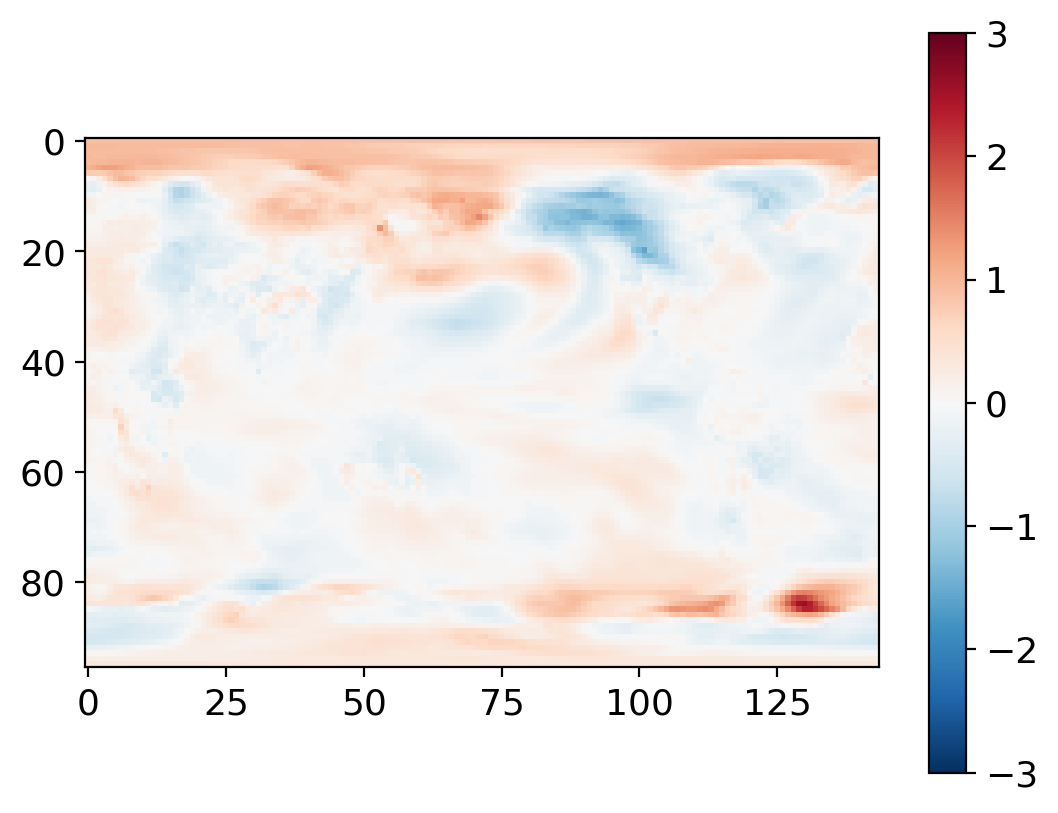

In [7]:
plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r',vmin=-3,vmax=3)
plt.colorbar()


Let's normalize the input predictors by there mean & standard deviation

In [8]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(753, 2) (753, 96, 144) (86, 2) (86, 96, 144)


### 2. Define the CNN architecture and perform hyperparameter tuning


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

We use <a href="https://keras.io/keras_tuner/">keras_tuner</a> to perform hyperparameter tuning.

In hyperparameter tuning, we keep the model structure but provide some options for hyperparameters (e.g. number of filters, learning rate, loss functions, etc).

![](https://drive.google.com/uc?export=view&id=1Gtnd8ktOYInwdwTdZkKENGrBftbBRRfx)

Here we set up the CNN model with hyperparameter options.

In [9]:
minibatch_size = 64
num_epochs     = 80
n_trials       = 10   # total number of trials in hyperparameter tuning


In [10]:
def build_model(hp):
    
    # options for hyperparameters
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    # build CNN models according to the hyperparameters
    model = keras.models.Sequential()

    model.add(Dense(hp_filters*12*18, input_shape=(X_train.shape[1],), activation=hp_activation)) 
    model.add(Reshape((12,18,hp_filters))) # shape: (12,18,filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=2, padding='same')) # shape: (24,36,filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=2, padding='same')) # shape: (48,72,filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=2, padding='same')) # shape: (96,144,filters)
    
    model.add(Conv2DTranspose(filters=1, kernel_size=hp_kernel_size, 
                              activation="linear", padding="same")) # shape: (96,144,1)
    
    model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    
    return model


### 3. Instantiate the tuner and perform hypertuning

There are a few built-in Tuner subclasses available for widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Check <a href="https://keras.io/api/keras_tuner/tuners/">here</a> for more information.

Here we display RandomSearch tuner as an example.

In [11]:
# Instantiate the Tuner and save the trials in a directory with customized project name
random_tuner = keras_tuner.RandomSearch(build_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name='random_search_CNN_10trials')

Reloading Tuner from random_search/random_search_CNN_10trials/tuner0.json


In [12]:
random_tuner.search_space_summary()


Search space summary
Default search space size: 5
filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [14]:
# Perform hypertuning
random_tuner.search(X_train, y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])


In [15]:
# display the model structure with the best tuning
best_model = random_tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6912)              20736     
                                                                 
 reshape (Reshape)           (None, 12, 18, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 36, 32)       9248      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 72, 32)       9248      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 144, 32)      9248      
 ranspose)                                                       
                                                        

In [24]:
# check hyperparameters of the all tuning trials
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

Ranking # 1 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 3, 'activation': 'tanh', 'learning_rate': 0.01, 'loss': 'mse'}
Ranking # 2 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 3, 'activation': 'tanh', 'learning_rate': 0.001, 'loss': 'mse'}
Ranking # 3 of best tuning, total trials =  10
{'filters': 64, 'kernel_size': 2, 'activation': 'sigmoid', 'learning_rate': 1e-05, 'loss': 'mae'}


### 4. Re-instantiate the hypermodel, re-train and save the model

In [33]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])


Epoch 1/80
10/10 [==============================] - 10s 912ms/step - loss: 2.5509 - val_loss: 0.4350
Epoch 2/80
10/10 [==============================] - 9s 912ms/step - loss: 1.0368 - val_loss: 0.5310
Epoch 3/80
10/10 [==============================] - 9s 901ms/step - loss: 0.6545 - val_loss: 0.9084
Epoch 4/80
10/10 [==============================] - 9s 911ms/step - loss: 0.5282 - val_loss: 0.4752
Epoch 5/80
10/10 [==============================] - 10s 989ms/step - loss: 0.4423 - val_loss: 0.4488
Epoch 6/80
10/10 [==============================] - 9s 889ms/step - loss: 0.4077 - val_loss: 0.4863
Epoch 7/80
10/10 [==============================] - 9s 900ms/step - loss: 0.3920 - val_loss: 0.5092
Epoch 8/80
10/10 [==============================] - 9s 911ms/step - loss: 0.4107 - val_loss: 0.6809
Epoch 9/80
10/10 [==============================] - 9s 889ms/step - loss: 0.4089 - val_loss: 0.6281
Epoch 10/80
10/10 [==============================] - 9s 911ms/step - loss: 0.3999 - val_loss: 0.43

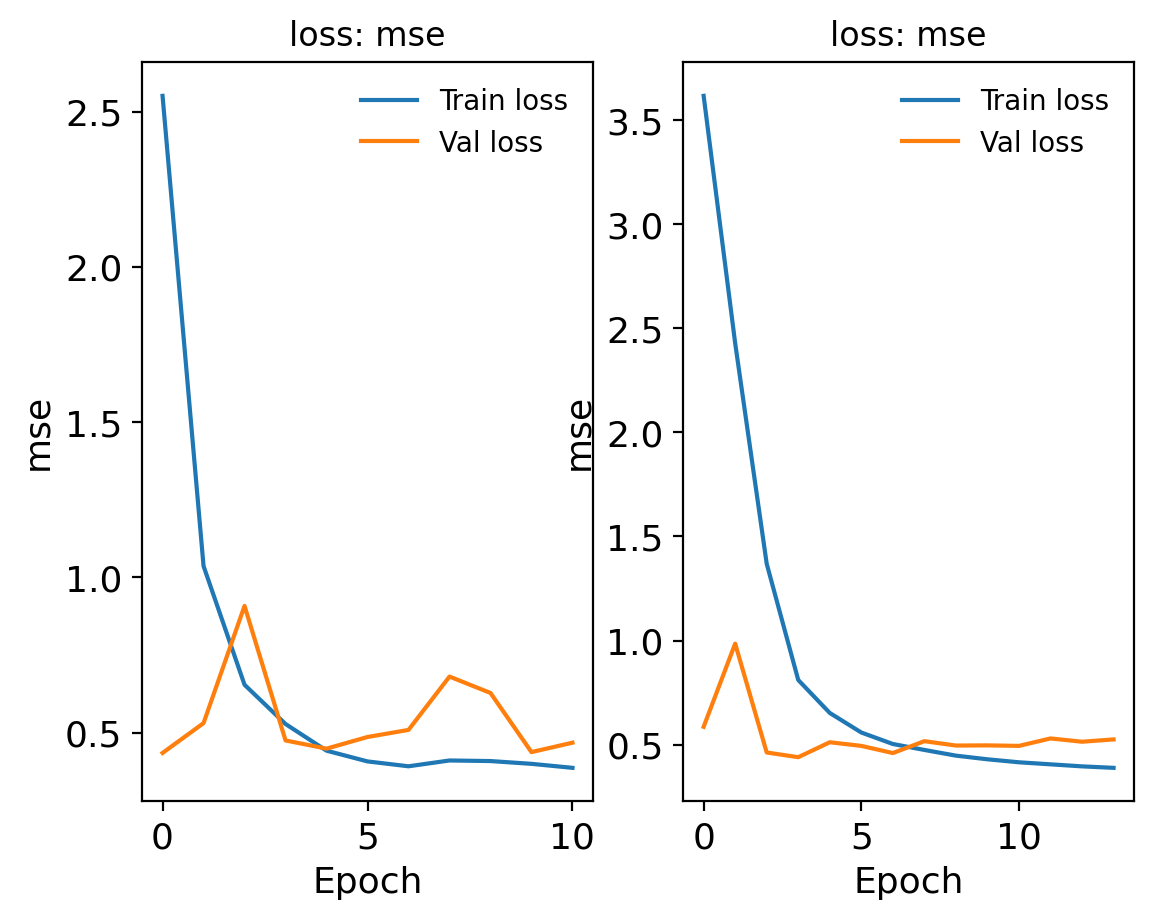

In [34]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')


In [36]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)


In [37]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_best.save(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank2.h5'))


### 5. Evaluate the trained model

In [38]:
## reload the saved model
# ---------- best tuning ----------
model_best = load_model(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank1.h5'))
# ---------- rank #2 tuning ----------
model_top2 = load_model(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank2.h5'))


In [40]:
## generate the prediction from the model
# ---------- best tuning ----------
y_test_best_pre = model_best.predict(X_test)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], 96, 144)
y_test_best_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                                     'latitude': X_test_xr.latitude.values, 
                                     'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(X_test)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], 96, 144)
y_test_top2_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                                     'latitude': X_test_xr.latitude.values, 
                                     'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_top2_pre)))


3/3 [==============================] - 1s 198ms/step


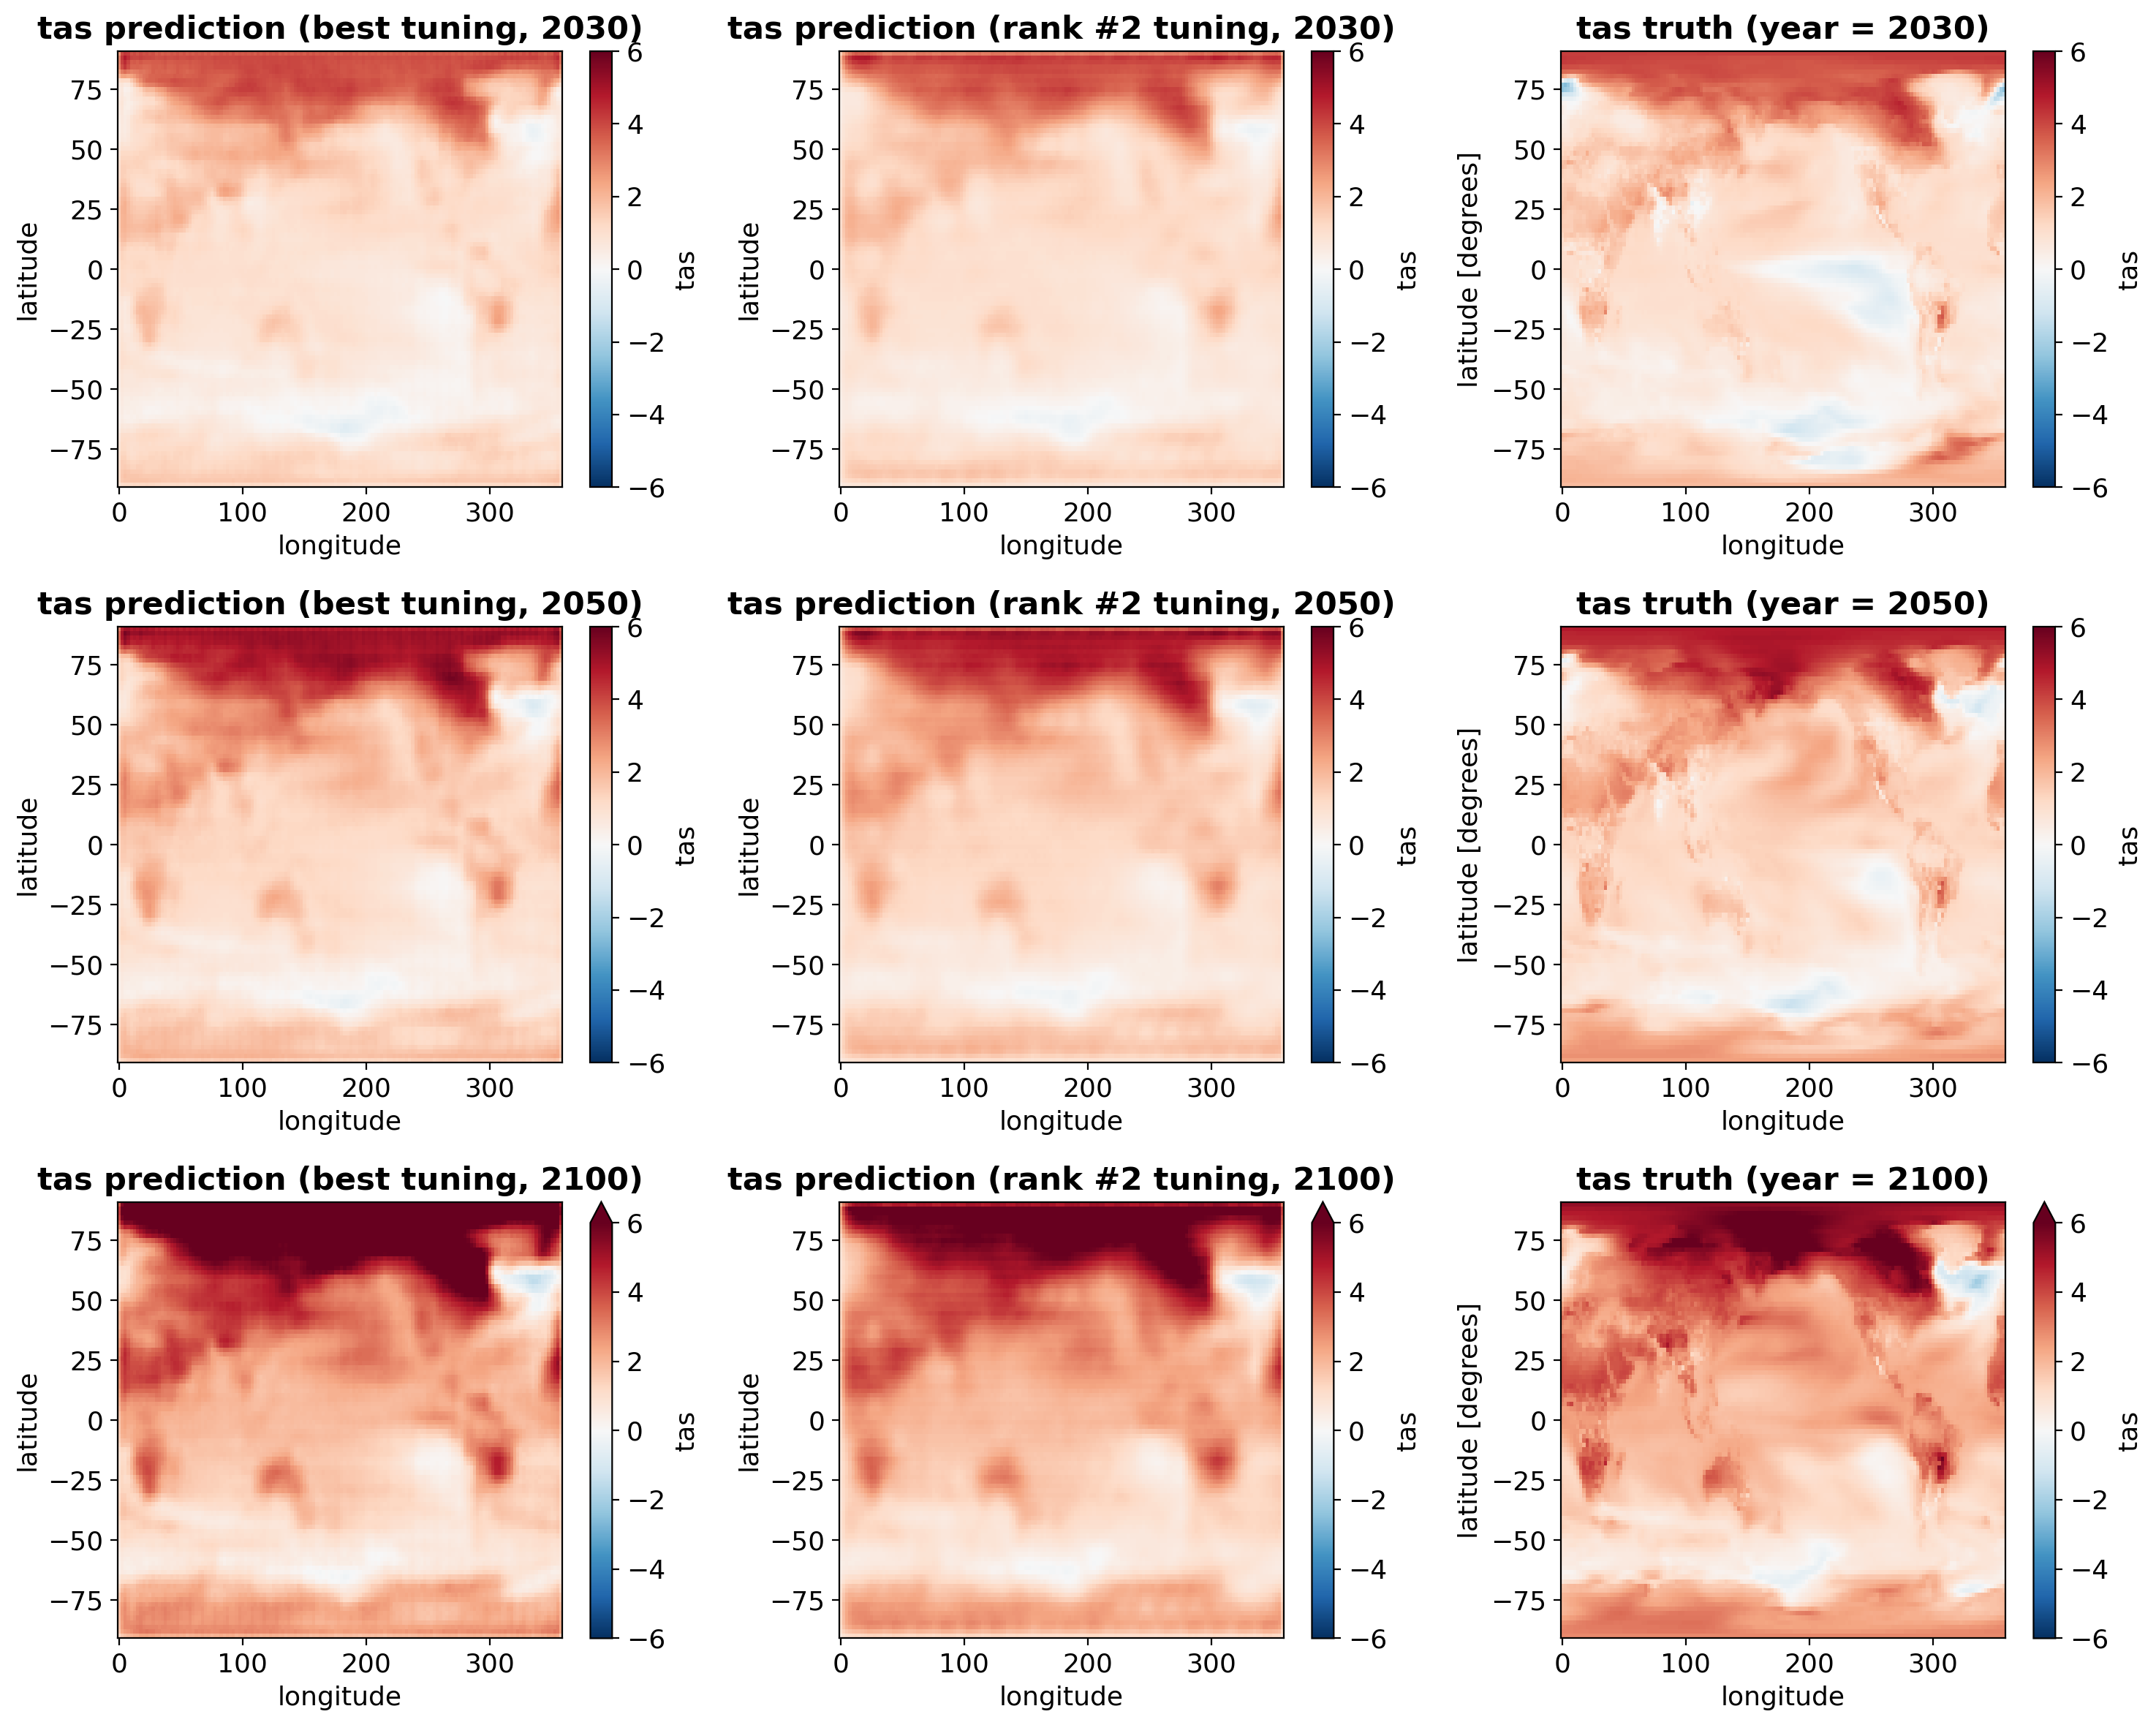

In [41]:
fig, axes = plt.subplots(figsize=(15,12),ncols=3,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_best_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_top2_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_best_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_top2_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_best_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_top2_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,2], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 3 == 0:
        ax.set_title(f'tas prediction (best tuning, {yrs[i//3]})',fontweight='bold')
    # middle column: model prediction (rank #2 tuning)
    elif i % 3 == 1:
        ax.set_title(f'tas prediction (rank #2 tuning, {yrs[i//3]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//3]})',fontweight='bold')
plt.tight_layout()


Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

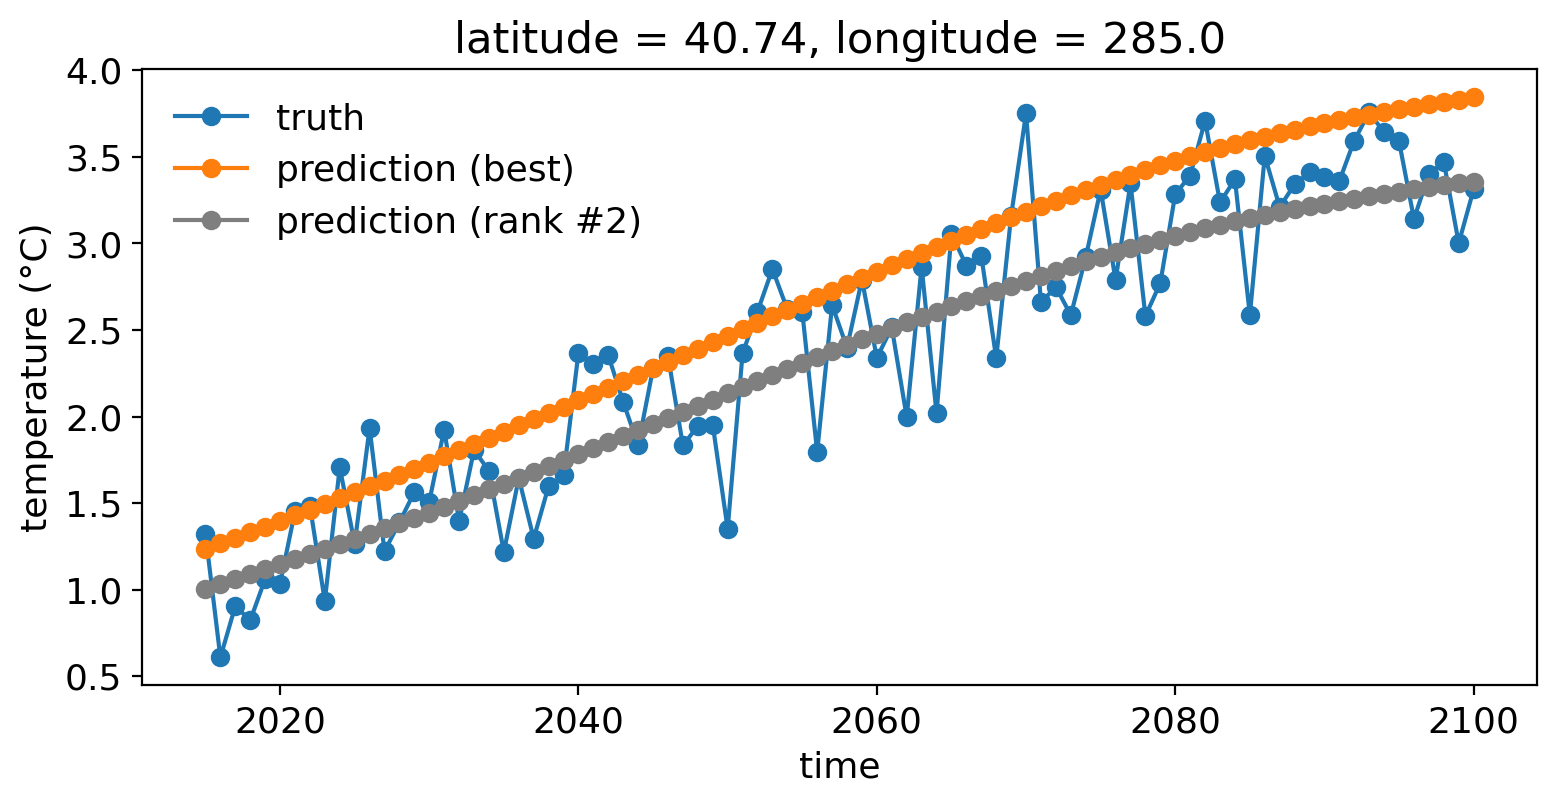

In [42]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:blue',label='truth')
y_test_best_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:orange',label='prediction (best)')
y_test_top2_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:gray',label='prediction (rank #2)')

ax.legend()
ax.set_ylabel('temperature (°C)')

Let's check the statistical comparison between truth and prediction.

In [43]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_best_pre = y_test_best_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_top2_pre = y_test_top2_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction_best"] = nyc_test_best_pre
df_nyc_test["prediction_rank2"] = nyc_test_top2_pre
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

   time     truth  prediction_best  prediction_rank2
0  2015  1.321960         1.236804          1.004055
1  2016  0.608693         1.268234          1.032432
2  2017  0.905599         1.299934          1.061073
3  2018  0.822795         1.331906          1.089976
4  2019  1.061228         1.364150          1.119142
5  2020  1.035349         1.396668          1.148568
6  2021  1.451701         1.429307          1.177227
7  2022  1.484253         1.462196          1.206123
8  2023  0.934296         1.495332          1.235256
9  2024  1.707011         1.528720          1.264624


,time,truth,prediction_best,prediction_rank2
count,86.000000,86.000000,86.000000,86.000000
mean,2057.500000,2.395548,2.678301,2.316881
std,24.969982,0.836997,0.821370,0.746932
min,2015.000000,0.608693,1.236804,1.004055
25%,2036.250000,1.691455,1.957439,1.655496
50%,2057.500000,2.456390,2.745380,2.394117
75%,2078.750000,3.155296,3.443723,3.014916
max,2100.000000,3.757050,3.843012,3.357242


Finally we check whether the ML model can capture the time series of global average temperature 

In [44]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)
    

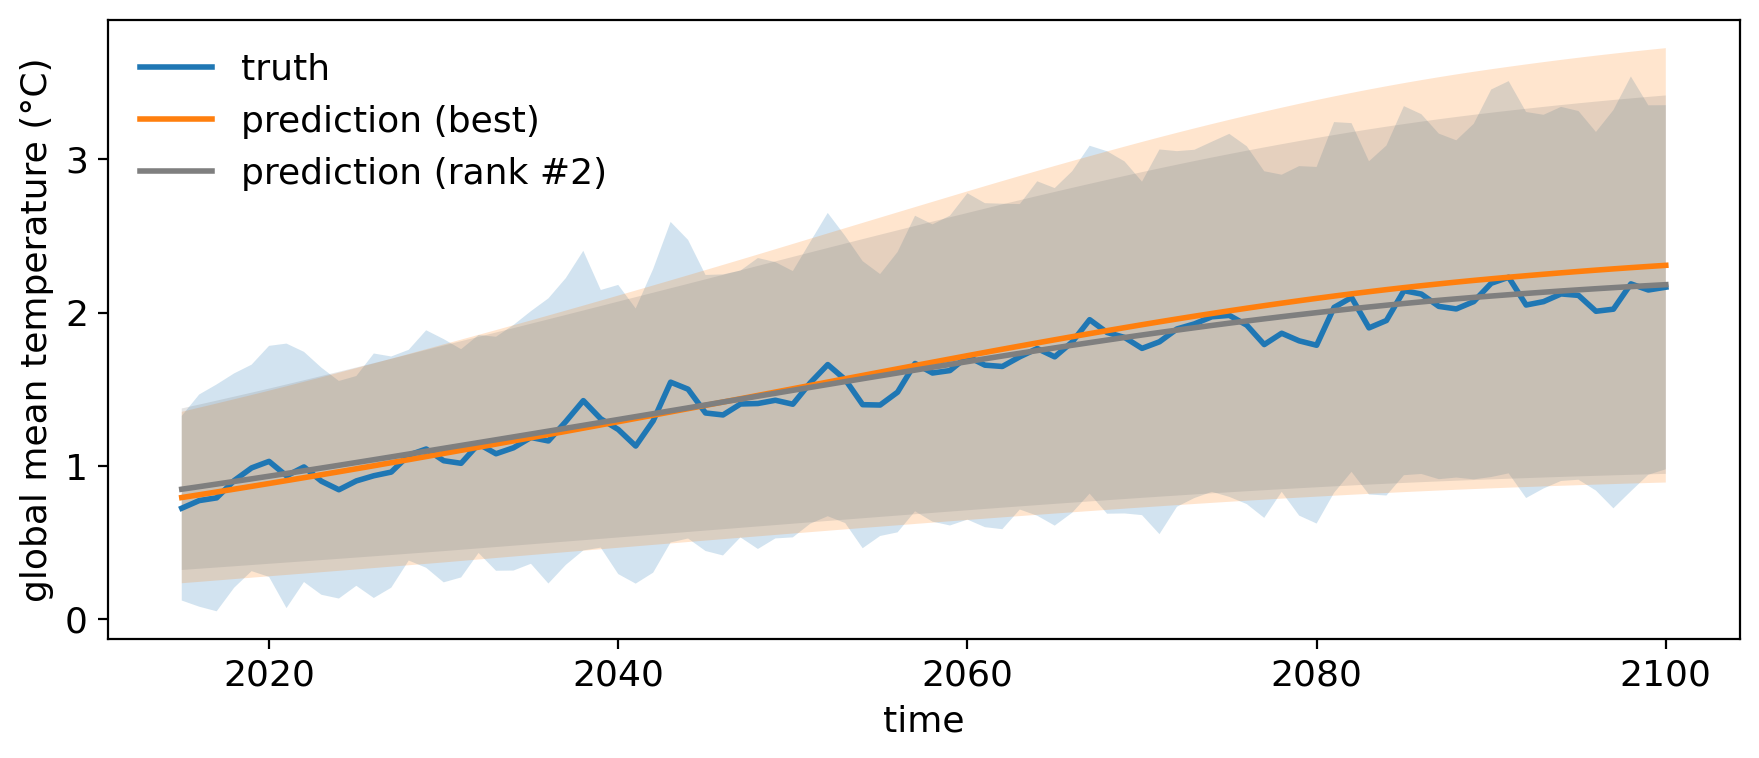

In [45]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_best_pre,label='prediction (best)',ax=ax,color='tab:orange')
global_mean_std_plot(y_test_top2_pre,label='prediction (rank #2)',ax=ax,color='tab:gray')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend(loc='upper left')
plt.tight_layout()


In [46]:
# get global mean temperature
def global_mean(X,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
    return tas_mean

tas_mean_xr = global_mean(y_test_xr)
tas_mean_best_pre = global_mean(y_test_best_pre)
tas_mean_top2_pre = global_mean(y_test_top2_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_globalmean_test["truth"] = tas_mean_xr
df_globalmean_test["prediction_best"] = tas_mean_best_pre
df_globalmean_test["prediction_rank2"] = tas_mean_top2_pre
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

   time     truth  prediction_best  prediction_rank2
0  2015  0.724876         0.794496          0.848691
1  2016  0.774634         0.812466          0.865374
2  2017  0.792321         0.830603          0.882211
3  2018  0.905029         0.848910          0.899201
4  2019  0.987700         0.867387          0.916343
5  2020  1.030206         0.886036          0.933638
6  2021  0.935918         0.904915          0.951194
7  2022  0.994084         0.923953          0.968888
8  2023  0.900831         0.943151          0.986719
9  2024  0.845252         0.962510          1.004686


,time,truth,prediction_best,prediction_rank2
count,86.000000,86.000000,86.000000,86.000000
mean,2057.500000,1.564246,1.629159,1.595258
std,24.969982,0.430099,0.477115,0.418334
min,2015.000000,0.724876,0.794496,0.848691
25%,2036.250000,1.169074,1.210322,1.232073
50%,2057.500000,1.635698,1.665843,1.634580
75%,2078.750000,1.943204,2.073639,1.983543
max,2100.000000,2.230782,2.308428,2.182407
